# Ranking features with XGBoost

In [65]:
import xgboost
from xgboost import XGBRegressor, XGBClassifier

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, r2_score, mean_squared_error

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from category_encoders import MEstimateEncoder, TargetEncoder
from sklearn.inspection import permutation_importance

import seaborn as sns
import shap


## Exploration of Data

In [66]:
df = pd.read_csv('../Dataset/train.csv/train.csv')
print(df.shape)
print('-'*100)
print(df.info())
print('-'*100)
display(df.describe())
print('-'*100)
display(df.isnull().sum())

cols_with_na = df.columns[df.isna().any()].tolist()
print(f"Number of columns with NAN: {len(cols_with_na)}")


(30471, 292)
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Columns: 292 entries, id to price_doc
dtypes: float64(119), int64(157), object(16)
memory usage: 67.9+ MB
None
----------------------------------------------------------------------------------------------------


,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
count,30471.000000,30471.000000,24088.000000,30304.000000,20899.000000,20899.000000,1.686600e+04,20899.000000,20899.000000,16912.000000,...,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,3.047100e+04
mean,15237.917397,54.214269,34.403271,7.670803,12.558974,1.827121,3.068057e+03,1.909804,6.399301,2.107025,...,32.058318,10.783860,1.771783,15.045552,30.251518,0.442421,8.648814,52.796593,5.987070,7.123035e+06
std,8796.501536,38.031487,52.285733,5.319989,6.756550,1.481154,1.543878e+05,0.851805,28.265979,0.880148,...,73.465611,28.385679,5.418807,29.118668,47.347938,0.609269,20.580741,46.292660,4.889219,4.780111e+06
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+05
25%,7620.500000,38.000000,20.000000,3.000000,9.000000,1.000000,1.967000e+03,1.000000,1.000000,1.000000,...,2.000000,1.000000,0.000000,2.000000,9.000000,0.000000,0.000000,11.000000,1.000000,4.740002e+06
50%,15238.000000,49.000000,30.000000,6.500000,12.000000,1.000000,1.979000e+03,2.000000,6.000000,2.000000,...,8.000000,2.000000,0.000000,7.000000,16.000000,0.000000,2.000000,48.000000,5.000000,6.274411e+06
75%,22855.500000,63.000000,43.000000,11.000000,17.000000,2.000000,2.005000e+03,2.000000,9.000000,3.000000,...,21.000000,5.000000,1.000000,12.000000,28.000000,1.000000,7.000000,76.000000,10.000000,8.300000e+06
max,30473.000000,5326.000000,7478.000000,77.000000,117.000000,6.000000,2.005201e+07,19.000000,2014.000000,33.000000,...,377.000000,147.000000,30.000000,151.000000,250.000000,2.000000,106.000000,218.000000,21.000000,1.111111e+08


----------------------------------------------------------------------------------------------------


id                       0
timestamp                0
full_sq                  0
life_sq               6383
floor                  167
                      ... 
mosque_count_5000        0
leisure_count_5000       0
sport_count_5000         0
market_count_5000        0
price_doc                0
Length: 292, dtype: int64

Number of columns with NAN: 51


In [67]:
# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month

df.drop(['timestamp'], axis=1, inplace=True)

In [70]:
tmp = df.drop(df[df['build_year'] > 2018].index)
tmp.shape

(30469, 293)

In [48]:
# q = df['build_year'].quantile(0.99)
# df.drop(df[df['build_year'] > 2018].id, inplace=True)
# df.shape


(30469, 293)

### Handpicked categorical features

In [49]:
from utils import categorical_cols, one_hot_cols, target_encoding_cols, ordinal_cols, useless_cols, numeric_cols

In [50]:
categorical_cols

['id',
 'floor',
 'material',
 'max_floor',
 'state',
 'product_type',
 'sub_area',
 'ID_railroad_station_walk',
 'ID_railroad_station_avto',
 'water_1line',
 'ID_big_road1',
 'big_road1_1line',
 'ID_big_road2',
 'railroad_1line',
 'ID_railroad_terminal',
 'ID_bus_terminal',
 'ecology',
 'nuclear_reactor_raion',
 'culture_objects_top_25',
 'thermal_power_plant_raion',
 'incineration_raion',
 'oil_chemistry_raion',
 'radiation_raion',
 'railroad_terminal_raion',
 'big_market_raion',
 'nuclear_reactor_raion',
 'detention_facility_raion',
 'ID_metro']

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


<Axes: xlabel='floor', ylabel='price_doc'>

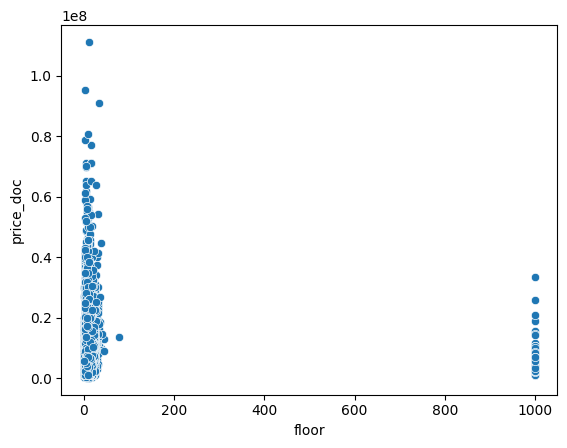

In [51]:
df_tmp = df.copy()
df_tmp[['floor']] = df_tmp[['floor']].fillna(1000)
sns.scatterplot(data=df_tmp, x='floor', y='price_doc')
# df_tmp

In [52]:
for c in categorical_cols:
    df[c] = df[c].astype('category')

In [53]:
cafe_list = []
for p in df.select_dtypes(include='number').columns:
    if 'cafe' in p:
        cafe_list.append(p)

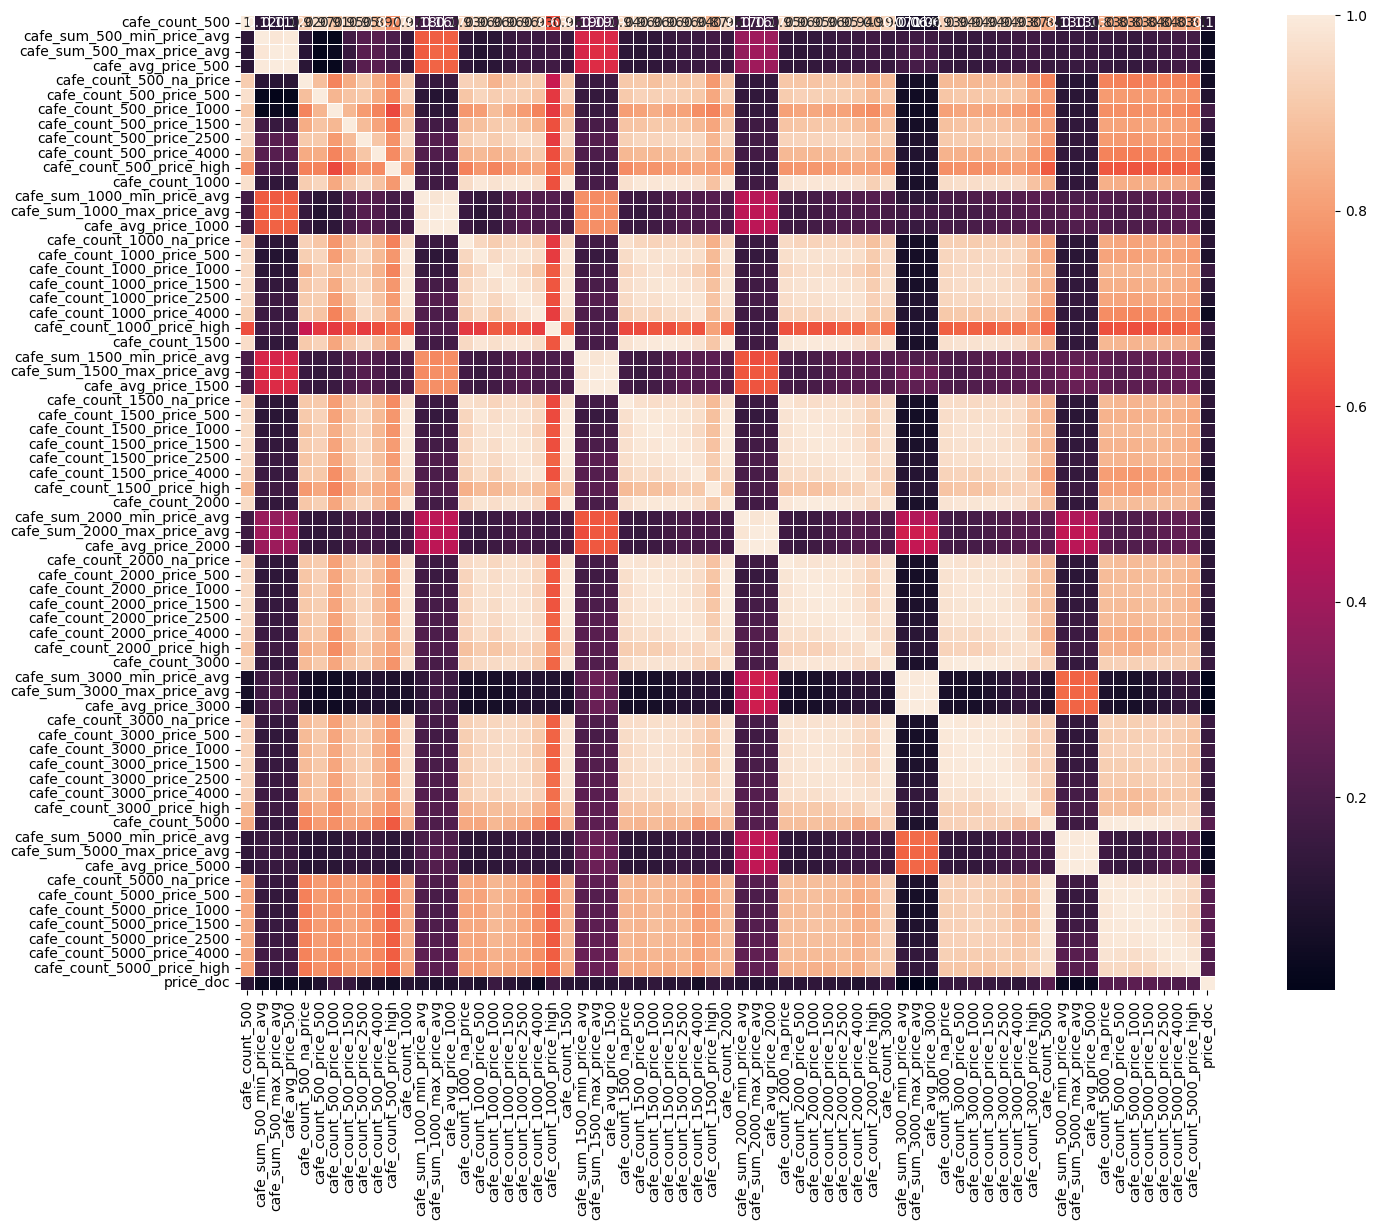

In [54]:
corrmat = df[cafe_list + ['price_doc']].corr()

plt.subplots(figsize=(18, 15))
sns.heatmap(corrmat, square=True, linewidths=.5, annot=True)
plt.subplots_adjust(top = 0.95, bottom = 0.3, left = 0.2, right = 1)
plt.show()

In [55]:
# Break down of one-hot cols
for c in one_hot_cols:
    print(f"Number of unique values for {c}: {df[c].nunique()}")
    display(df[c].value_counts().head(20))

Number of unique values for product_type: 2


product_type
Investment       19446
OwnerOccupier    11023
Name: count, dtype: int64

## Pre-processing

In [56]:
# Replacing NAN with mean
df2 = df.copy()
# useless_cols += cafe_list
df2.drop(useless_cols, axis=1, inplace=True)


In [57]:
for c in cols_with_na:
    if c not in useless_cols and df2[c].dtype.name != 'category':
        df2[c] = df2[c].fillna((df2[c].mean()))

print("Columns with NAN after update: ")
df2.columns[df2.isna().any()].tolist()

Columns with NAN after update: 


['floor', 'max_floor', 'material', 'state']

### One-hot Encoding

In [58]:
# One Hot Encoding
df2 = pd.get_dummies(df2, columns=one_hot_cols, dtype='int64')
df2.head()


,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,sub_area,...,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,year,month,product_type_Investment,product_type_OwnerOccupier
0,43,27.0,4.0,NaN,NaN,3068.187559,1.909748,6.399196,NaN,Bibirevo,...,22,1,0,52,4,5850000,2011,8,1,0
1,34,19.0,3.0,NaN,NaN,3068.187559,1.909748,6.399196,NaN,Nagatinskij Zaton,...,29,1,10,66,14,6000000,2011,8,1,0
2,43,29.0,2.0,NaN,NaN,3068.187559,1.909748,6.399196,NaN,Tekstil'shhiki,...,27,0,4,67,10,5700000,2011,8,1,0
3,89,50.0,9.0,NaN,NaN,3068.187559,1.909748,6.399196,NaN,Mitino,...,4,0,0,26,3,13100000,2011,9,1,0
4,77,77.0,4.0,NaN,NaN,3068.187559,1.909748,6.399196,NaN,Basmannoe,...,236,2,91,195,14,16331452,2011,9,1,0


### Ordinal Encoding
For ordinal values

In [59]:
# Label encoding
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
oe.fit(df2[ordinal_cols])
df2[ordinal_cols] = oe.transform(df2[ordinal_cols])

df2[ordinal_cols].head()



,ecology,floor,culture_objects_top_25,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,water_1line,big_road1_1line,railroad_1line,month,material,max_floor,state
0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,NaN,NaN,NaN
1,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,NaN,NaN,NaN
2,3.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,NaN,NaN,NaN
3,1.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,NaN,NaN,NaN
4,0.0,4.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,NaN,NaN,NaN


In [62]:
df2.select_dtypes(include='category').columns
# df2.dropna(subset=['build_year'], inplace=True)

print("Columns with NAN after update: ", df2.columns[df2.isna().any()].tolist())
print("Num NANs: ", df2.isnull().sum().sum())


# print("Droppping NANs")
# df2.dropna(inplace=True)

df2 = df2.apply(lambda x: x.fillna(x.value_counts().index[0]))

df2.shape


Columns with NAN after update:  ['floor', 'max_floor', 'material', 'state']
Num NANs:  32870


(30469, 286)

In [63]:
print("Columns with NAN after update: ", df2.columns[df2.isna().any()].tolist())
print("Num NANs: ", df2.isnull().sum().sum())

Columns with NAN after update:  []
Num NANs:  0


In [20]:
print("converting years to int")
df2[['year', 'build_year']] = df2[['year', 'build_year']].astype('int64')
df2.select_dtypes(exclude='number').columns

converting years to int


Index(['sub_area'], dtype='object')

### Target Encoding for sub_area
Due to the many different values, target encoding is more approriate. We will first split the dataset into train and test.

#### Split Dataset

In [21]:
y = df2['price_doc']
X = df2.copy()

display(y.head())
display(X.head())

8056    2750000
8135    9000000
8153    7011550
8154    7100000
8186    5903808
Name: price_doc, dtype: int64

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,sub_area,...,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,year,month,product_type_Investment,product_type_OwnerOccupier
8056,11,11.000000,2.0,5.0,1.0,1907,1.0,12.0,2.0,Hamovniki,...,207,1,89,161,10,2750000,2013,4.0,1,0
8135,53,30.000000,10.0,16.0,0.0,1980,2.0,8.0,2.0,Lianozovo,...,21,1,0,46,5,9000000,2013,4.0,1,0
8153,77,41.000000,2.0,17.0,5.0,2014,3.0,12.0,0.0,Poselenie Voskresenskoe,...,7,1,0,12,1,7011550,2013,4.0,0,1
8154,45,27.000000,6.0,9.0,0.0,1970,2.0,6.0,2.0,Severnoe Butovo,...,8,1,0,19,3,7100000,2013,4.0,1,0
8186,63,34.402848,17.0,17.0,3.0,2013,2.0,1.0,0.0,Nekrasovka,...,3,0,0,6,1,5903808,2013,4.0,0,1


In [22]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

- Testing with M Estimate Encoding
- Create the encoder instance. Choose m to control noise.

In [23]:
# m_encoder = MEstimateEncoder(cols=target_encoding_cols, m=10.0)

# # Fit the encoder on the encoding split.
# m_encoder.fit(X_train, y_train)

# # Encode the sub_area column to create the final training data
# X_train['sub_area_mestimate'] = m_encoder.transform(X_train)['sub_area']
# X_train[['sub_area_mestimate']].head()

# # Transform test data
# X_test['sub_area_mestimate'] = m_encoder.transform(X_test)['sub_area']


# plt.figure(dpi=90)
# ax = sns.distplot(y, kde=False, norm_hist=True)
# ax = sns.kdeplot(X_train['sub_area_mestimate'], color='r', ax=ax)
# ax.set_xlabel("price_doc")
# ax.legend(labels=['sub_area_mestimate', 'price_doc'])

- Testing with Target Encoding
- Smoothing = Regularization --> Making sth less complex --> prevent overfitting
- 'min_samples_leaf' is the minimum number of samples within a category to take it's mean into account.


is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a fig

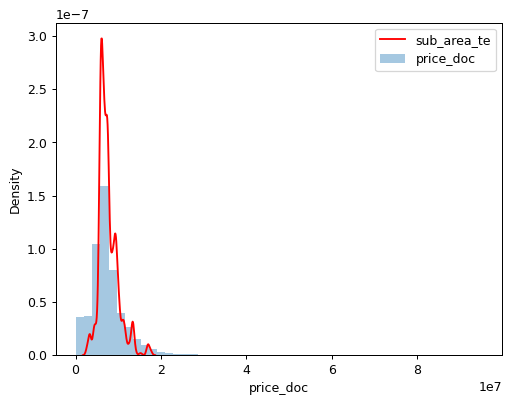

In [24]:
te_encoder = TargetEncoder(cols=target_encoding_cols, min_samples_leaf=5, smoothing=8)

# Fit the encoder on the encoding split.
te_encoder.fit(X_train, y_train)

# Encode the sub_area column to create the final training data
X_train['sub_area_te'] = te_encoder.transform(X_train)['sub_area']
X_train[['sub_area_te']].head()

# Transform test data
X_test['sub_area_te'] = te_encoder.transform(X_test)['sub_area']

plt.figure(dpi=90)
ax = sns.distplot(y, kde=False, norm_hist=True)
ax = sns.kdeplot(X_train['sub_area_te'], color='r', ax=ax)
ax.set_xlabel("price_doc")
ax.legend(labels=['sub_area_te', 'price_doc'])

In [25]:
# Drop 'sub_area'
X_train.drop(['sub_area', 'price_doc'], axis=1, inplace=True)
X_test.drop(['sub_area', 'price_doc'], axis=1, inplace=True)

In [26]:
print(X_train.info())

print(X_train.shape)


<class 'pandas.core.frame.DataFrame'>
Index: 12682 entries, 28522 to 21490
Columns: 285 entries, full_sq to sub_area_te
dtypes: float64(132), int64(153)
memory usage: 27.7 MB
None
(12682, 285)


No more cat data type!

### Testing

In [27]:
# Convert to DMatrix
train_data = xgboost.DMatrix(X_train, label=y_train)
test_data = xgboost.DMatrix(X_test, label=y_test)

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecat

In [28]:
params = {
    'objective': 'reg:squarederror',
    'tree_method': 'gpu_hist',
}

In [29]:
n = 100
model = xgboost.train(
    params=params,
    dtrain=train_data,
    num_boost_round=n,
    )

[23:02:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"



In [30]:
pred = model.predict(test_data)

[23:02:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"



In [31]:
rmse = mean_squared_error(y_test, pred, squared=False)
r2 = r2_score(y_test, pred)

print(f"RMSE: {rmse}")
print(f"R2: {r2}")


RMSE: 2771376.518489727
R2: 0.7180999297373546


- Weight. The number of times a feature is used to split the data across all trees.
- Cover. The number of times a feature is used to split the data across all trees weighted by the number of training data points that go through those splits.
- Gain. The average training loss reduction gained when using a feature for splitting.  [*MOST IMPORTANT*]

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

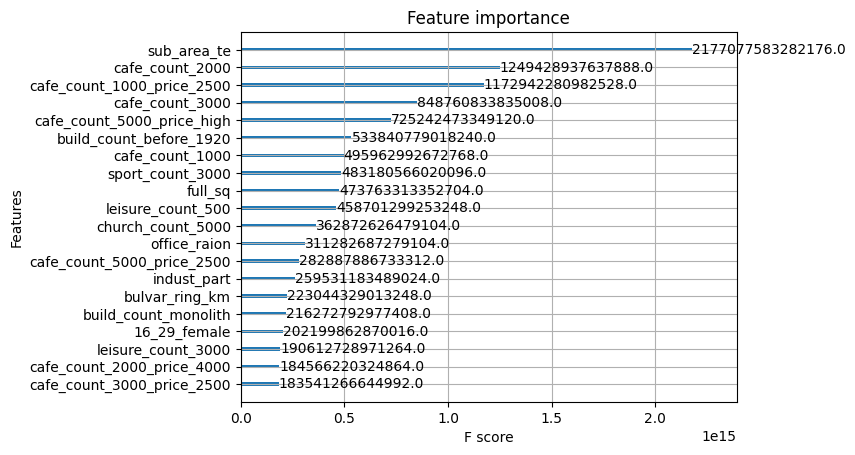

In [32]:
limit = 20
xgboost.plot_importance(model, importance_type='gain', max_num_features=limit)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

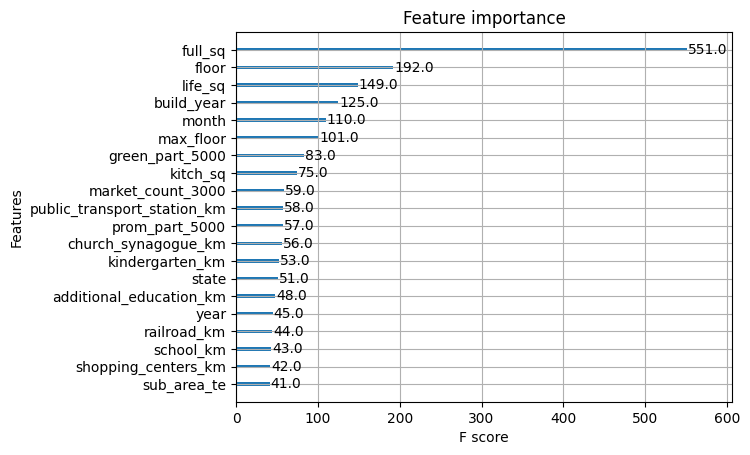

In [33]:
xgboost.plot_importance(model, importance_type='weight', max_num_features=limit)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

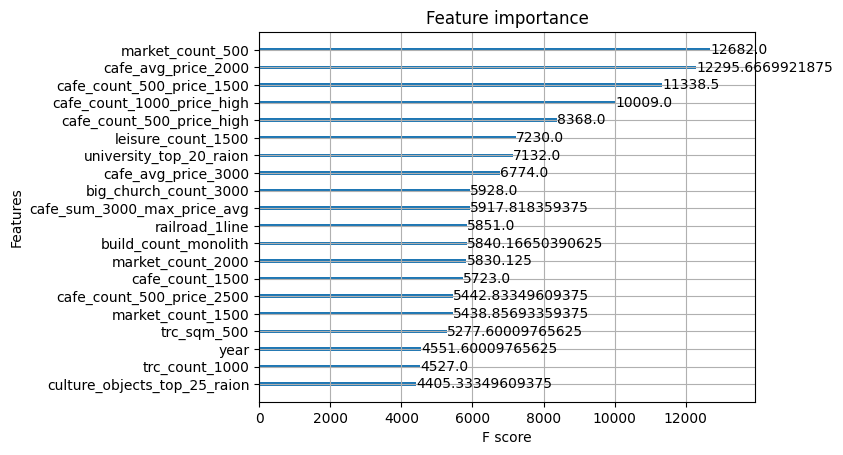

In [34]:
xgboost.plot_importance(model, importance_type='cover', max_num_features=limit)

In [35]:
from utils import params2

In [36]:
model2 = XGBRegressor(
                      n_estimators=params2['n_estimators'],
                      device=params2['device'],
                      objective=params2['objective'],
                      eval_metric=params2['eval_metric'],
                      enable_categorical=params2['enable_categorical'],
                      
                      eta=params2['eta'],
                    #   max_depth = params2['max_depth'],
                    #   gamma = params2['gamma'],
                    #   reg_alpha = params2['reg_alpha'],
                    #   min_child_weight=params2['min_child_weight'],
                    #   colsample_bytree=params2['colsample_bytree']                     
                      )

model2.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecat

[0]	validation_0-rmsle:0.61958	validation_1-rmsle:0.62660
[1]	validation_0-rmsle:0.60734	validation_1-rmsle:0.61480
[2]	validation_0-rmsle:0.59641	validation_1-rmsle:0.60407
[3]	validation_0-rmsle:0.58648	validation_1-rmsle:0.59463
[4]	validation_0-rmsle:0.57737	validation_1-rmsle:0.58595
[5]	validation_0-rmsle:0.56899	validation_1-rmsle:0.57793
[6]	validation_0-rmsle:0.56157	validation_1-rmsle:0.57060
[7]	validation_0-rmsle:0.55454	validation_1-rmsle:0.56405
[8]	validation_0-rmsle:0.54823	validation_1-rmsle:0.55806
[9]	validation_0-rmsle:0.54239	validation_1-rmsle:0.55256
[10]	validation_0-rmsle:0.53677	validation_1-rmsle:0.54755
[11]	validation_0-rmsle:0.53170	validation_1-rmsle:0.54281
[12]	validation_0-rmsle:0.52683	validation_1-rmsle:0.53824
[13]	validation_0-rmsle:0.52242	validation_1-rmsle:0.53426
[14]	validation_0-rmsle:0.51835	validation_1-rmsle:0.53054
[15]	validation_0-rmsle:0.51452	validation_1-rmsle:0.52714
[16]	validation_0-rmsle:0.51096	validation_1-rmsle:0.52407
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=True, eta=0.05, eval_metric='rmsle',
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [37]:
pred = model2.predict(X_test)

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
[23:02:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.



In [38]:
rmse = mean_squared_error(y_test, pred, squared=False)
r2 = r2_score(y_test, pred)

print(f"RMSE: {rmse}")
print(f"R2: {r2}")


RMSE: 2720275.9699564525
R2: 0.7283998230819816


In [39]:
sorted_idx = model2.feature_importances_.argsort()[::-1]

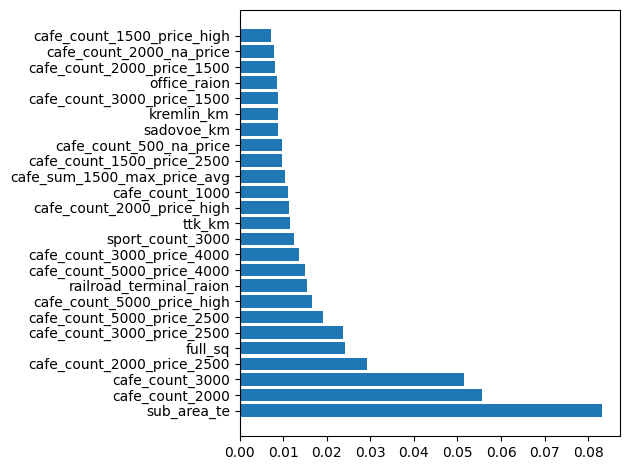

In [40]:
# limit = len(sorted_idx)
limit = 25
plt.barh(model2.feature_names_in_[sorted_idx[:limit]], model2.feature_importances_[sorted_idx[:limit]])
plt.tight_layout()

In [41]:
# perm_importance = permutation_importance(model2, X_test, y_test)

In [42]:
# sorted_idx = perm_importance.importances_mean.argsort()[::-1]

# plt.barh(model2.feature_names_in_[sorted_idx[:limit]], perm_importance.importances_mean[sorted_idx[:limit]])
# plt.xlabel("Permutation Importance")

In [43]:
explainer = shap.TreeExplainer(model2)
shap_values = explainer.shap_values(X_test)

[23:02:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


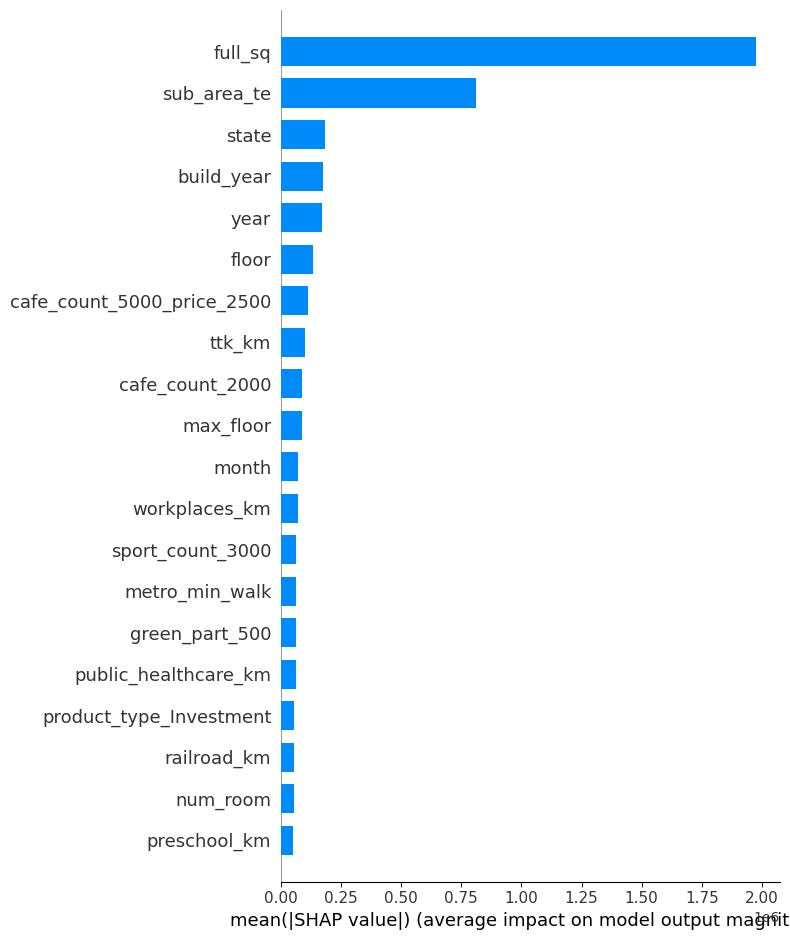

In [44]:
shap.summary_plot(shap_values, X_test, plot_type="bar")